In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


In [2]:
# Data yükləmə
df=pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Kategorik sütunları dummy dəyişənlərə çeviririk
df = pd.get_dummies(df, drop_first=True)

In [7]:
# Kategorik sütunları dummy dəyişənlərə çeviririk
df = pd.get_dummies(df, drop_first=True)
df['sex_male'] = df['sex_male'].astype(int)
df['smoker_yes'] = df['smoker_yes'].astype(int)
df['region_northwest'] = df['region_northwest'].astype(int)
df['region_southeast'] = df['region_southeast'].astype(int)
df['region_southwest'] = df['region_southwest'].astype(int)

In [8]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


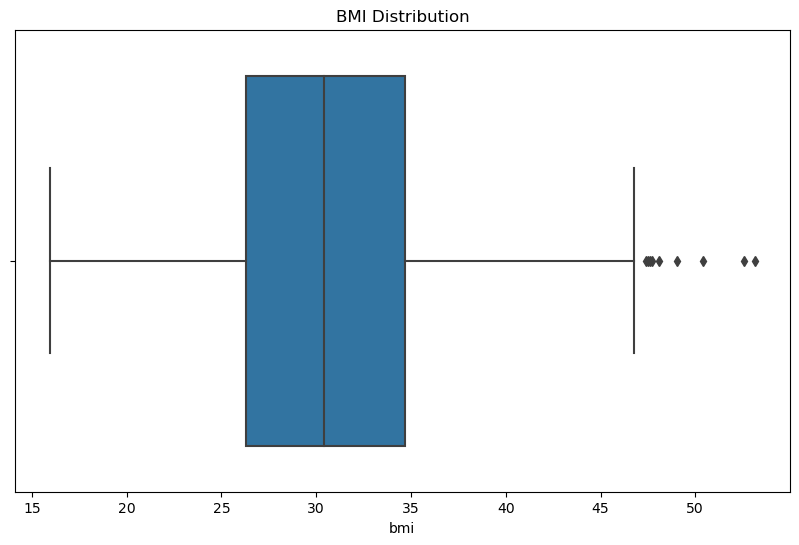

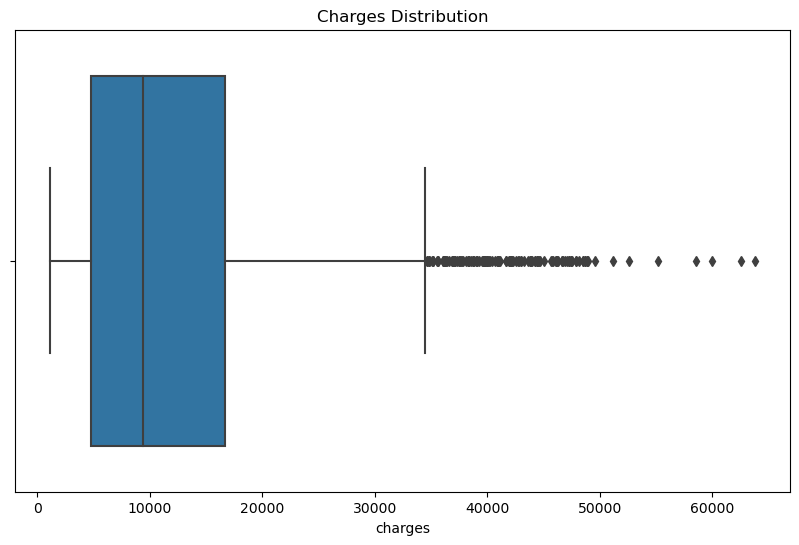

In [9]:
# Outlier-lərin təyini üçün BMI və Charges sütunlarını görsəlləşdirək
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['bmi'])
plt.title('BMI Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['charges'])
plt.title('Charges Distribution')
plt.show()

In [10]:
# Outlier-ləri silmək üçün bir təyin edilmiş metod istifadə edək
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

df_cleaned = remove_outliers(df, 'bmi')
df_cleaned = remove_outliers(df_cleaned, 'charges')

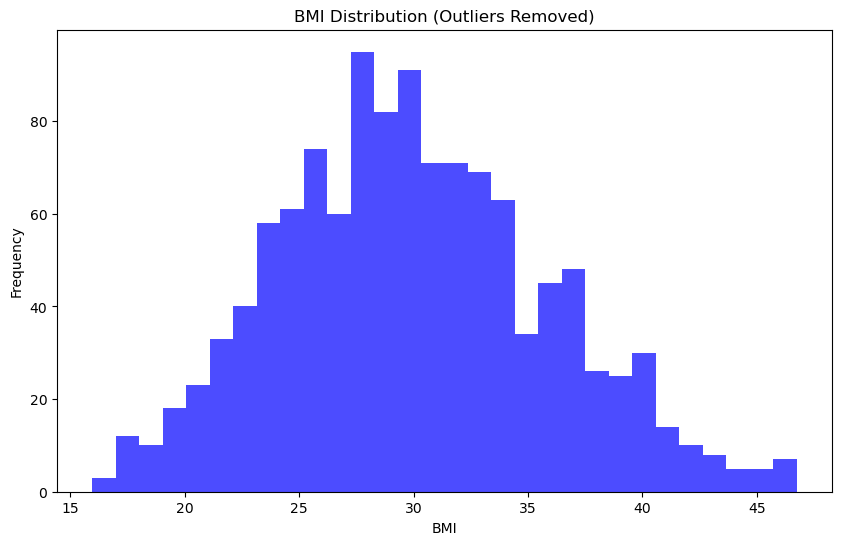

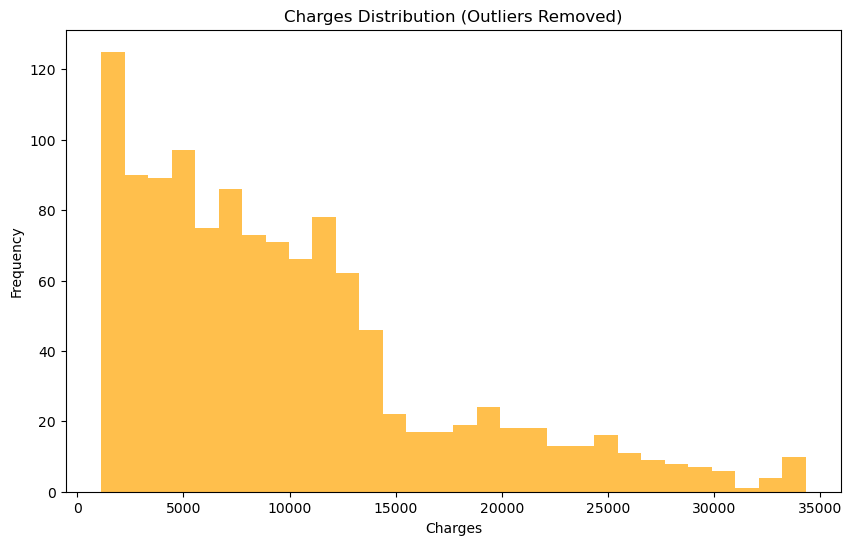

In [11]:
# Viziuallasdirmaq üçün yeni dataların histogramlarını hazırlayaq

plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['bmi'], bins=30, color='blue', alpha=0.7)
plt.title('BMI Distribution (Outliers Removed)')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['charges'], bins=30, color='orange', alpha=0.7)
plt.title('Charges Distribution (Outliers Removed)')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

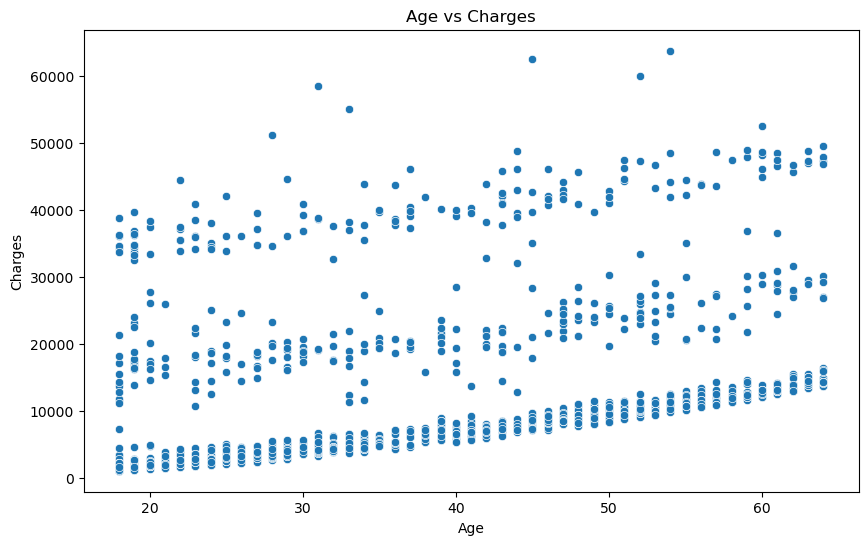

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='charges')
plt.title('Age vs Charges')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()


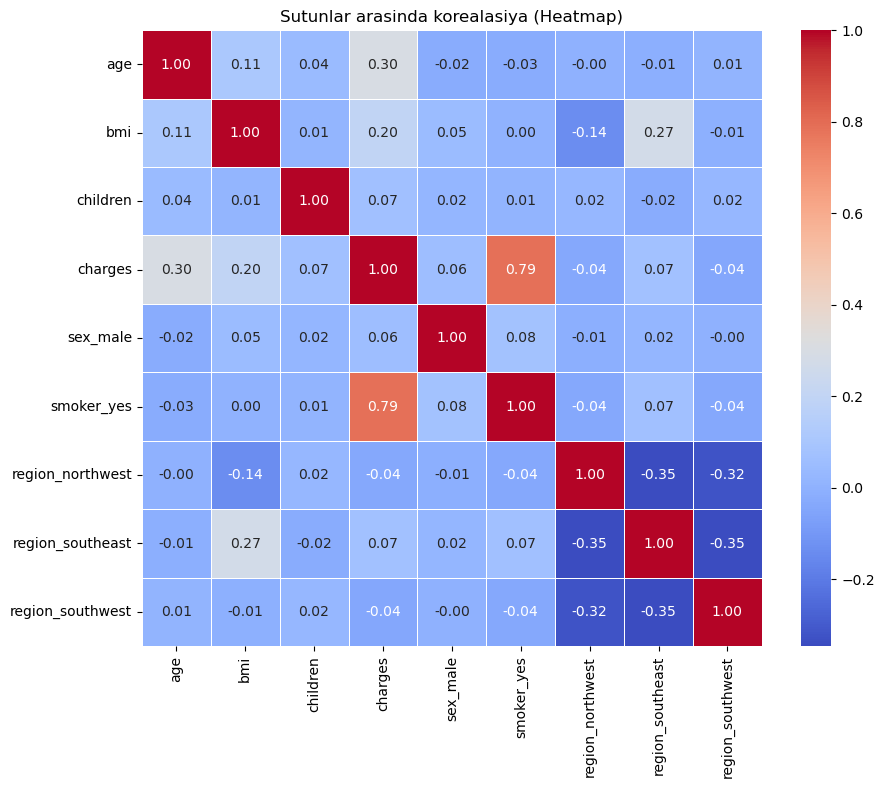

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Sutunlar arasinda korealasiya (Heatmap)')
plt.show()

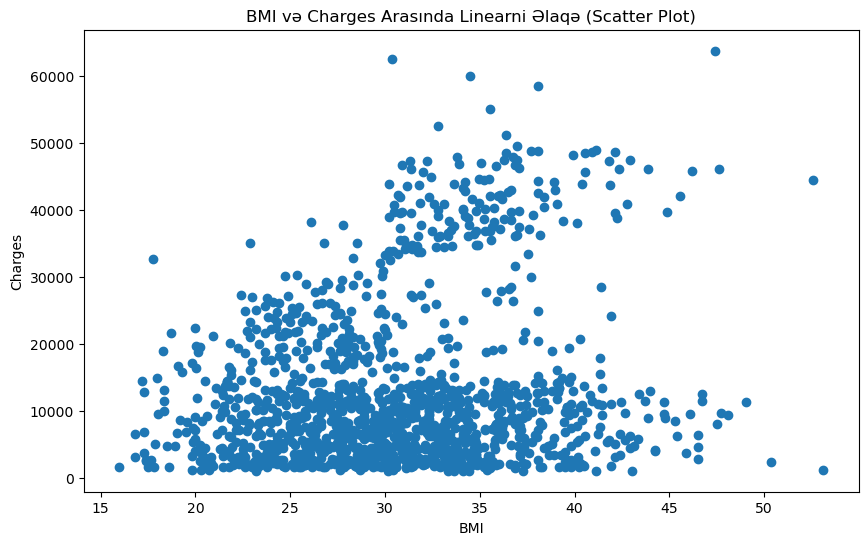

In [14]:
# Scatter Plot: BMI və Charges sütunları arasında linearni əlaqəni göstərmək
plt.figure(figsize=(10, 6))
plt.scatter(df['bmi'], df['charges'])
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('BMI və Charges Arasında Linearni Əlaqə (Scatter Plot)')
plt.show()

In [15]:
# Verilənləri model üçün hazırlayırıq
X = df_cleaned.drop('charges', axis=1)
y = df_cleaned['charges']

In [16]:
# Verilənləri train və test bölmələrə ayırırıq
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Dataları standartlaşdırmaq üçün StandardScaler istifadə edirik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Linear Regression modelini təlim edirik
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_y_pred = linear_model.predict(X_test_scaled)

In [19]:
# Coefficients ve  intercept
coef = linear_model.coef_
intercept = linear_model.intercept_
print("Coef :", coef)
print("Intercept:", intercept)

Coef : [3380.90127971  357.07564223  491.00045054  -79.27366756 4553.78040518
 -176.72929271 -464.75981999 -531.06449511]
Intercept: 9748.929001784667


In [20]:
# RandomForestRegression modelini təlim edirik
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)

In [21]:
# XGBoost modelini təlim edirik
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_y_pred = xgb_model.predict(X_test_scaled)

In [22]:
# Modelin nəticələrini qiymətləndiririk
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Model - Mean Squared Error:", mse)
    print(f"{model_name} Model - Root Mean Squared Error:", rmse)
    print(f"{model_name} Model - R-squared:", r2)

In [23]:
#linear regression

print("Linear Regression Results:")
evaluate_model(y_test, linear_y_pred, "Linear Regression")

Linear Regression Results:
Linear Regression Model - Mean Squared Error: 19877696.620193187
Linear Regression Model - Root Mean Squared Error: 4458.44105267673
Linear Regression Model - R-squared: 0.632813516344632


In [24]:
#RandomForest Regression
print("RandomForest Regression Results:")
evaluate_model(y_test, rf_y_pred, "RandomForest Regression")


RandomForest Regression Results:
RandomForest Regression Model - Mean Squared Error: 20224742.744825117
RandomForest Regression Model - Root Mean Squared Error: 4497.192762693759
RandomForest Regression Model - R-squared: 0.6264027813080398


In [25]:
#XGBoost Regression
print("XGBoost Regression Results:")
evaluate_model(y_test, xgb_y_pred, "XGBoost Regression")

XGBoost Regression Results:
XGBoost Regression Model - Mean Squared Error: 23918617.157639638
XGBoost Regression Model - Root Mean Squared Error: 4890.666330638355
XGBoost Regression Model - R-squared: 0.5581684791843202


In [26]:
# RandomForestRegression modeli üçün parametrləri grid üzərində təyin edirik
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [27]:
# Randomforest-GridSearchCV istifadə edərək ən yaxşı parametrləri tapırıq
rf_grid_search = GridSearchCV(estimator=rf_model,
                              param_grid=rf_param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5, verbose=2, n_jobs=-1)

rf_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [28]:
# Ən yaxşı parametrləri tapdıqdan sonra təlim edilmiş RandomForestRegression modelini əldə edirik
best_rf_model = rf_grid_search.best_estimator_
best_rf_y_pred = best_rf_model.predict(X_test_scaled)


In [29]:
# XGBoost modeli üçün parametrləri təyin edirik
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [30]:
# XGBoost-GridSearchCV istifadə edərək ən yaxşı parametrləri tapırıq
xgb_grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=xgb_param_grid,
                               scoring='neg_mean_squared_error',
                               cv=5, verbose=2, n_jobs=-1)

xgb_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [31]:
# Ən yaxşı parametrləri tapdıqdan sonra təlim edilmiş XGBoost modelini əldə edirik
best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_y_pred = best_xgb_model.predict(X_test_scaled)

In [32]:
# Modelin nəticələrini qiymətləndiririk
best_rf_mse = mean_squared_error(y_test, best_rf_y_pred)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_r2 = r2_score(y_test, best_rf_y_pred)
print("Best RandomForest Regression Model - Mean Squared Error:", best_rf_mse)
print("Best RandomForest Regression Model - Root Mean Squared Error:", best_rf_rmse)
print("Best RandomForest Regression Model - R-squared:", best_rf_r2)

Best RandomForest Regression Model - Mean Squared Error: 18837023.197305687
Best RandomForest Regression Model - Root Mean Squared Error: 4340.16395972614
Best RandomForest Regression Model - R-squared: 0.652037132746719


In [33]:
best_xgb_mse = mean_squared_error(y_test, best_xgb_y_pred)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_r2 = r2_score(y_test, best_xgb_y_pred)
print("Best XGBoost Regression Model - Mean Squared Error:", best_xgb_mse)
print("Best XGBoost Regression Model - Root Mean Squared Error:", best_xgb_rmse)
print("Best XGBoost Regression Model - R-squared:", best_xgb_r2)

Best XGBoost Regression Model - Mean Squared Error: 18818856.324291654
Best XGBoost Regression Model - Root Mean Squared Error: 4338.070576222989
Best XGBoost Regression Model - R-squared: 0.6523727164085735


In [34]:
# Linear Regression modelinin Cross-Validation nəticəsi
linear_cv_scores = cross_val_score(linear_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
linear_cv_rmse = np.sqrt(-1 * linear_cv_scores.mean())
print("Linear Regression Model - Cross-Validation Root Mean Squared Error:", linear_cv_rmse)

Linear Regression Model - Cross-Validation Root Mean Squared Error: 4572.210221649867


In [35]:
# RandomForestRegression modelinin Cross-Validation nəticəsi
rf_cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
rf_cv_rmse = np.sqrt(-1 * rf_cv_scores.mean())
print("Best RandomForest Regression Model - Cross-Validation Root Mean Squared Error:", rf_cv_rmse)


Best RandomForest Regression Model - Cross-Validation Root Mean Squared Error: 4344.497628427655


In [36]:
# XGBoost modelinin Cross-Validation nəticəsi
xgb_cv_scores = cross_val_score(best_xgb_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
xgb_cv_rmse = np.sqrt(-1 * xgb_cv_scores.mean())
print("Best XGBoost Regression Model - Cross-Validation Root Mean Squared Error:", xgb_cv_rmse)

Best XGBoost Regression Model - Cross-Validation Root Mean Squared Error: 4396.3841300242575


In [37]:
models = [
    ("Linear Regression", linear_model),
    ("Best RandomForest Regression", best_rf_model),
    ("Best XGBoost Regression", best_xgb_model)
]

In [38]:
# Modellər üçün ən yaxşı Cross-Validation nəticələri
cv_results = []
for name, model in models:
    cv_scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
    cv_rmse = np.sqrt(-1 * cv_scores.mean())
    cv_results.append((name, cv_rmse))

In [39]:
cv_results_df = pd.DataFrame(cv_results, columns=["Model", "Cross-Validation RMSE"])
print(cv_results_df)

                          Model  Cross-Validation RMSE
0             Linear Regression            4572.210222
1  Best RandomForest Regression            4344.497628
2       Best XGBoost Regression            4396.384130


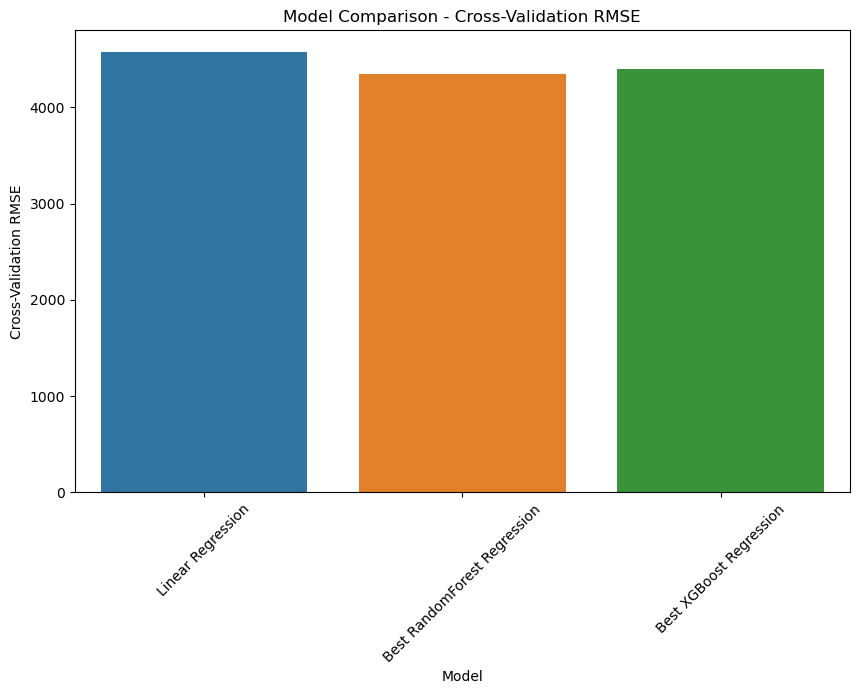

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Cross-Validation RMSE", data=cv_results_df)
plt.title("Model Comparison - Cross-Validation RMSE")
plt.xticks(rotation=45)
plt.show()

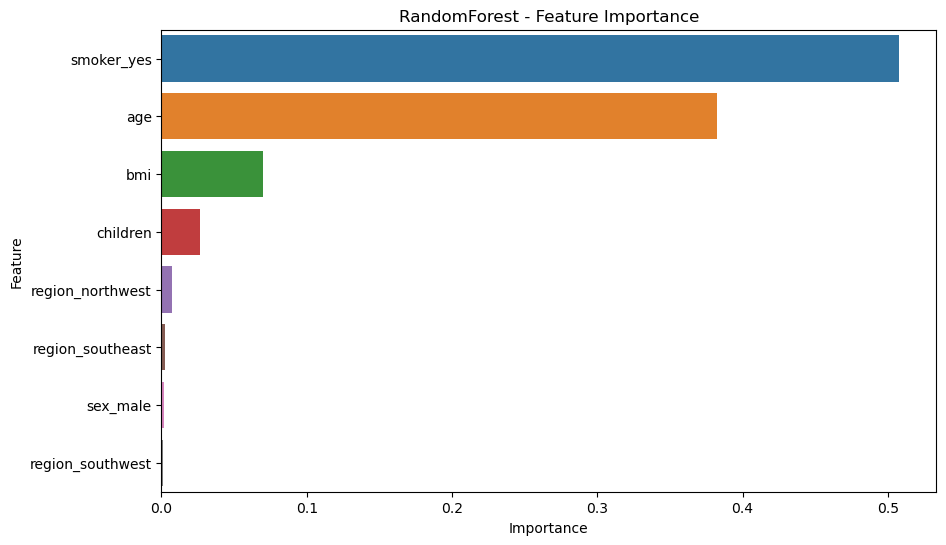

In [41]:
# RandomForest modelində ən vacib xüsusiyyətlərinin görsəlləşdirilməsi
feature_importance_rf = best_rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df_rf)
plt.title("RandomForest - Feature Importance")
plt.show()

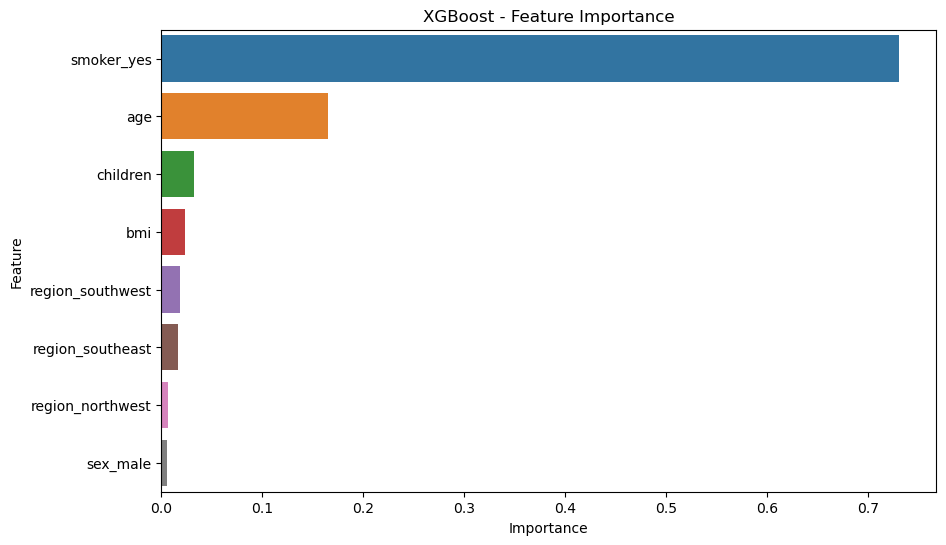

In [42]:
# XGBoost modelində ən vacib xüsusiyyətlərinin görsəlləşdirilməsi
feature_importance_xgb = best_xgb_model.feature_importances_
feature_importance_df_xgb = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df_xgb)
plt.title("XGBoost - Feature Importance")
plt.show()

In [43]:
# Linear Regression Model
linear_y_pred = linear_model.predict(X_test_scaled)

# Xetalar
residuals = y_test - linear_y_pred

# güven aralığı %95 güven aralığı)
confidence_interval = 1.96 * residuals.std()

# Texminlerin asagi ve yuxari serhedleri
lower_bound = linear_y_pred - confidence_interval
upper_bound = linear_y_pred + confidence_interval


In [44]:

residuals

1069     -639.557766
282     -2243.293401
299     -1359.977807
177      -624.629700
637     16046.796510
            ...     
417     -3162.290762
404     -1369.133070
159      8581.408051
459     -1408.485780
923     -2803.495607
Name: charges, Length: 239, dtype: float64

In [45]:
confidence_interval

8756.33870597256

In [46]:
upper_bound 

array([20324.74547208, 15236.75865728, 19365.81171307, 19817.06440571,
       17624.58845611, 21265.9439907 , 18869.96413111, 29126.50311189,
       20505.47345343, 20140.90796863, 18568.13726966, 15253.2213385 ,
       11511.82131831, 14561.22381779, 21087.34089607, 19223.974499  ,
       22904.17063065, 16423.38464369, 16320.70882048, 14703.28341446,
       20147.12311313, 20974.36322864, 17933.87175637, 29344.45601983,
       31645.41600887, 32244.69316723, 12771.41231966, 16685.75496244,
       15240.96743213, 22054.34564752, 17482.57803703, 12226.79198166,
       20261.63469001, 11426.41551471, 13228.43744065, 12177.80384534,
       22605.14659443, 20002.34434057, 19128.74845929, 12551.57794019,
       20909.09417243, 13399.46065071, 13337.79153608, 14107.28389277,
       20326.51250774, 11770.80089257, 20537.91397364, 16491.13306658,
       21704.9532277 , 14918.69100749, 21183.4869499 , 14966.10213622,
       14169.14999348, 16424.65487246, 14143.14346419, 14469.93659663,
      

In [47]:
lower_bound

array([ 2812.06806013, -2275.91875466,  1853.13430113,  2304.38699376,
         111.91104417,  3753.26657876,  1357.28671916, 11613.82569995,
        2992.79604149,  2628.23055669,  1055.45985771, -2259.45607345,
       -6000.85609363, -2951.45359415,  3574.66348412,  1711.29708706,
        5391.4932187 , -1089.29276826, -1191.96859147, -2809.39399749,
        2634.44570119,  3461.68581669,   421.19434442, 11831.77860789,
       14132.73859693, 14732.01575528, -4741.26509228,  -826.92244951,
       -2271.70997981,  4541.66823557,   -30.09937492, -5285.88543029,
        2748.95727807, -6086.26189723, -4284.2399713 , -5334.8735666 ,
        5092.46918248,  2489.66692862,  1616.07104734, -4961.09947175,
        3396.41676048, -4113.21676123, -4174.88587586, -3405.39351917,
        2813.8350958 , -5741.87651937,  3025.2365617 , -1021.54434537,
        4192.27581575, -2593.98640446,  3670.80953795, -2546.57527572,
       -3343.52741846, -1088.02253948, -3369.53394775, -3042.74081532,
      